In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import skimage
import sklearn

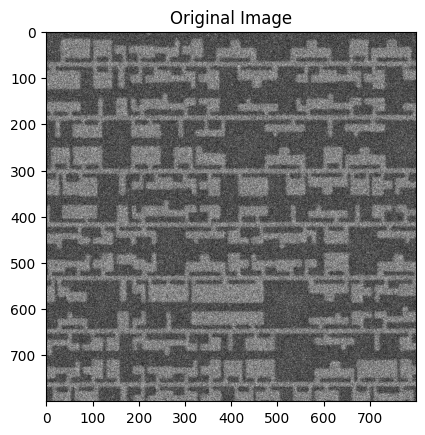

Type <class 'numpy.ndarray'> uint8
Shape (800, 800)
Range 0 - 255


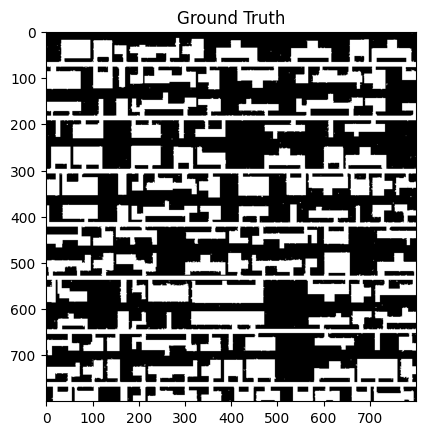

Type <class 'numpy.ndarray'> bool
Shape (800, 800)
Range False - True


In [2]:
# load and show original image

def imshow(img:np.ndarray, title:str):
    plt.figure()
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.show()
    # print image statistics
    print('Type', type(img), img.dtype)
    print('Shape', img.shape)
    print('Range', np.min(img), '-', np.max(img))

original_image = skimage.io.imread('img_0.png')
imshow(original_image, 'Original Image')

# load and show ground truth
ground_truth = skimage.io.imread('gt_0.png').astype('bool')
imshow(ground_truth, 'Ground Truth')

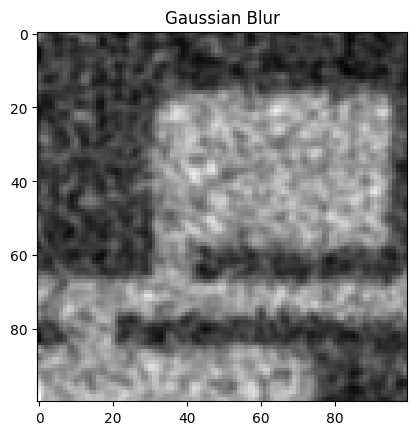

Type <class 'numpy.ndarray'> float64
Shape (100, 100)
Range 0.18701638339792598 - 0.7106708581970249


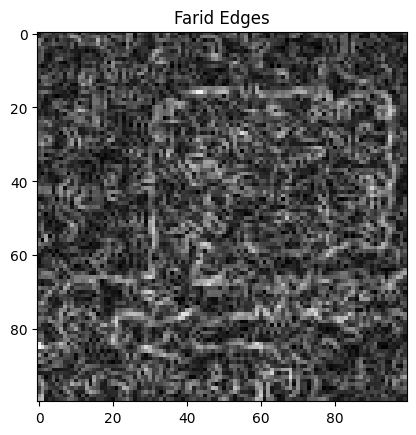

Type <class 'numpy.ndarray'> float64
Shape (100, 100)
Range 0.0003618963572120814 - 0.11310742596480271


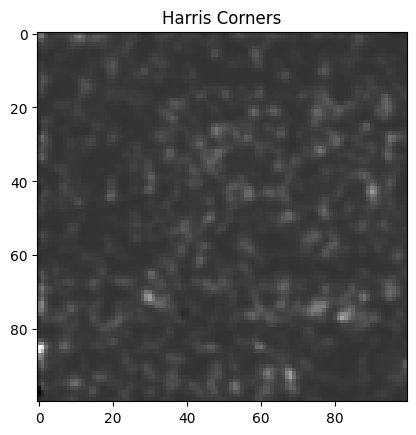

Type <class 'numpy.ndarray'> float64
Shape (100, 100)
Range -0.2331053845414695 - 0.9422119927366289
(640000, 3)


In [3]:
# feature extraction - intensity, edges, corners
intensity = skimage.filters.gaussian(original_image)
imshow(intensity[0:100, 0:100], 'Gaussian Blur')

edges = skimage.filters.farid(original_image)
imshow(edges[0:100, 0:100], 'Farid Edges')

corners = skimage.feature.corner_harris(original_image)
imshow(corners[0:100, 0:100], 'Harris Corners')

# format features
features = np.dstack((intensity, edges, corners))
features = features.reshape(800*800, -1)
print(features.shape)

feature_names = ['intensity', 'edges', 'corners']

In [4]:
# train/test split 
import sklearn.model_selection

test_percent = 0.20
n_test_rows = int(test_percent*800)
n_train_rows = 800-n_test_rows
print(n_test_rows, n_train_rows)

feats_train, feats_test, gt_train, gt_test = sklearn.model_selection.train_test_split(
features, ground_truth.flatten().astype(int), test_size=test_percent, shuffle=False)

160 640


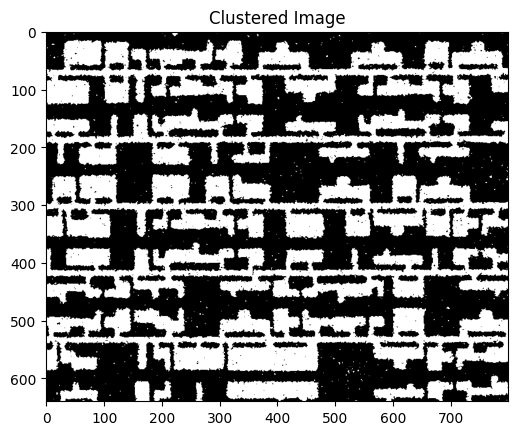

Type <class 'numpy.ndarray'> int32
Shape (640, 800)
Range 0 - 1
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]


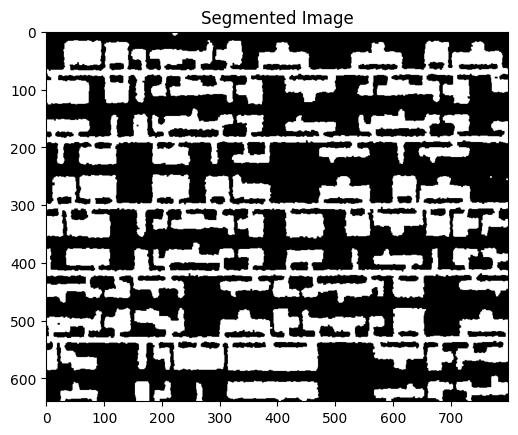

Type <class 'numpy.ndarray'> bool
Shape (640, 800)
Range False - True
Iou 0.881151818449434


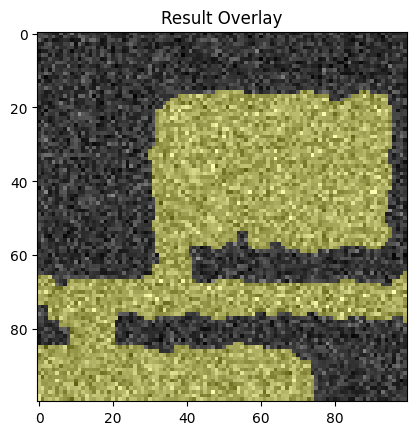

Type <class 'numpy.ndarray'> float64
Shape (100, 100, 3)
Range 0.002745098039215686 - 1.0


In [5]:
# TRAINING

# supervised ML - decision tree
from sklearn import tree
model = sklearn.tree.DecisionTreeClassifier(min_impurity_decrease=0.01, random_state=1)
model.fit(feats_train, gt_train)
clustered_image = model.predict(feats_train)
clustered_image = clustered_image.reshape(n_train_rows,800)
imshow(clustered_image, 'Clustered Image')

# postprocessing - morphological operations 
# input: clustered_image, out: segmentation
structuring_element = np.ones([3,3])
print(structuring_element)
postprocess_image = skimage.morphology.binary_opening(clustered_image, structuring_element)
segmentation = skimage.morphology.binary_closing(postprocess_image, structuring_element)
imshow(segmentation, 'Segmented Image')

# evaluation - IoU
import sklearn.metrics
iou = sklearn.metrics.jaccard_score(segmentation.flatten(),
                                   gt_train.flatten())
print('Iou', iou)

# visualize results
visualization = skimage.color.label2rgb(segmentation,
                                       original_image[0:n_train_rows, 0:800],
                                       ['yellow'])
imshow(visualization[0:100, 0:100], 'Result Overlay')

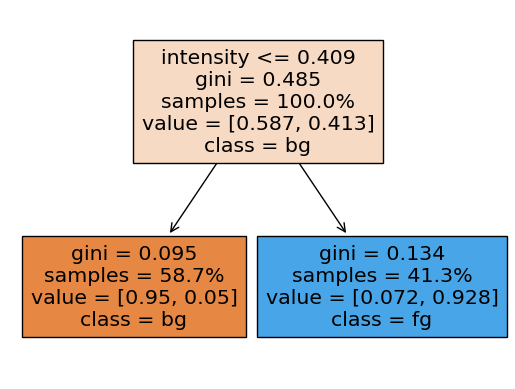

|--- intensity <= 0.41
|   |--- class: 0
|--- intensity >  0.41
|   |--- class: 1



In [6]:
# model interpretation 
sklearn.tree.plot_tree(model, 
                      feature_names=feature_names,
                      class_names=['bg','fg'],
                      proportion=True, filled=True)

plt.show()

print(sklearn.tree.export_text(model, feature_names=feature_names))

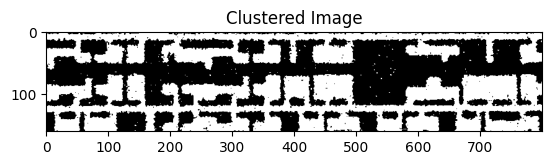

Type <class 'numpy.ndarray'> int32
Shape (160, 800)
Range 0 - 1
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]


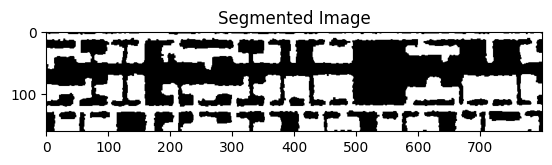

Type <class 'numpy.ndarray'> bool
Shape (160, 800)
Range False - True
Iou 0.889387099706123


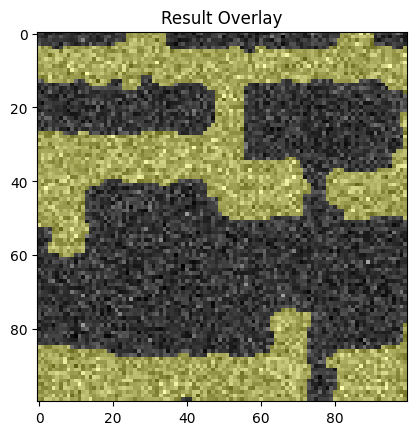

Type <class 'numpy.ndarray'> float64
Shape (100, 100, 3)
Range 0.005490196078431372 - 1.0


In [7]:
# TESTING

clustered_image = model.predict(feats_test)
clustered_image = clustered_image.reshape(n_test_rows,800)
imshow(clustered_image, 'Clustered Image')

# postprocessing - morphological operations 
# input: clustered_image, out: segmentation
structuring_element = np.ones([3,3])
print(structuring_element)
postprocess_image = skimage.morphology.binary_opening(clustered_image, structuring_element)
segmentation = skimage.morphology.binary_closing(postprocess_image, structuring_element)
imshow(segmentation, 'Segmented Image')

# evaluation - IoU
import sklearn.metrics
iou = sklearn.metrics.jaccard_score(segmentation.flatten(),
                                   gt_test.flatten())
print('Iou', iou)

# visualize results
visualization = skimage.color.label2rgb(segmentation,
                                       original_image[n_train_rows:800, 0:800],
                                       ['yellow'])
imshow(visualization[0:100, 0:100], 'Result Overlay')